In [1]:
import os
import time
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
from tensorboardX import SummaryWriter
os.chdir('../')

In [2]:
import model_basic
import config
import evaluate
import data_utils

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
test_data_without_neg = pd.read_csv('./data/final_movielens/test_df')   
sid_pop_total = pd.read_csv('./data/final_movielens/sid_pop_total')

### Load baseline and zerosum models

We load the 'MF' model for demonstration of the result.

In [4]:
model = 'MF'
model_baseline = torch.load(f'./models/final_movielens__{model}_none_1.0_20.pth')
model_zerosum = torch.load(f'./models/final_movielens__{model}_posneg_0.9_20.pth')

We load the relevant functions to evaluate the result.

When using the GNN models, different function from the pop_bias_metrics_graph.py must be loaded.

In [5]:
from pop_bias_metrics_basic import pred_item_rank, pred_item_score, pred_item_stdscore, pred_item_rankdist, raw_pred_score, pcc_train, pcc_test, uPO
import scipy.stats as stats
from scipy.stats import skew

In [6]:
model = 'MF'

baseline = pd.read_csv(f'./experiments/{model}_movielens_none_20_1.0_burninno_regno.csv')
zerosum = pd.read_csv(f'./experiments/{model}_movielens_posneg_20_0.9_burninno_regno.csv')

result = pd.concat([baseline.tail(1), zerosum.tail(1)])
result = result[['batch', 'sample', 'weight', 'HR', 'NDCG', 'SCC_rank', 'mean']]
result.columns = ['batch', 'sample', 'weight', 'HR', 'NDCG', 'iPO', 'PopQ@1']
result['sample'] = ['baseline', 'zerosum']
result

,batch,sample,weight,HR,NDCG,iPO,PopQ@1
20,2048,baseline,1.0,0.728839,0.475552,-0.910999,0.181087
20,2048,zerosum,0.9,0.718033,0.449557,-0.933155,0.383115


### Calculating the popularity-rank correlation for items (iPO)

In [7]:
baseline = pred_item_rank(model_baseline, test_data_without_neg, sid_pop_total)
zerosum = pred_item_rank(model_zerosum, test_data_without_neg, sid_pop_total)

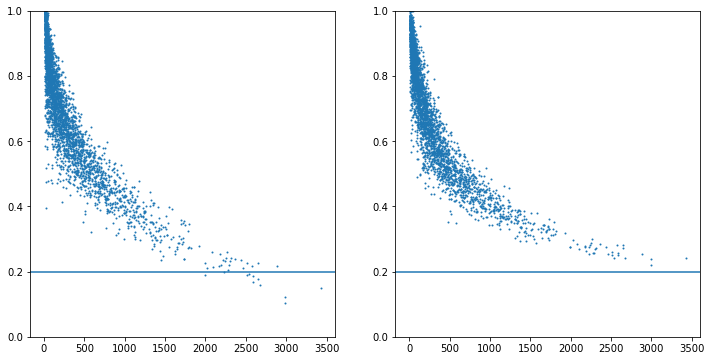

In [8]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(baseline['sid_pop_count'], baseline['rank'], s = 1)
ax1.set_ylim([0, 1])
ax1.axline((0, 0.2), slope=0., color='C0')
ax2.scatter(zerosum['sid_pop_count'], zerosum['rank'], s = 1)
ax2.set_ylim([0, 1])
ax2.axline((0, 0.2), slope=0., color='C0')

**Result**

The left corresponds to the item popularity(x) - item rank(y) plot for the baseline method.

The right corresponds to the item popularity(x) - item rank(y) plot for the zerosum method.


Both shows a similar correlation between item popularity and item rank, i.e. popular items are likely to be ranked higher among positive items.

However, we see that for the zerosum method, the average item rank of the most popular items increased from below 0.2 to agove 0.2.

Since the popular items is likely to be included in the recommendation list of numerous users, this indicate a vast reduction in model bias that the iPO score can not capture.



### Calculating the Pop Q @ 1

In [9]:
baseline = pred_item_rankdist(model_baseline, test_data_without_neg, sid_pop_total)
zerosum = pred_item_rankdist(model_zerosum, test_data_without_neg, sid_pop_total)

<AxesSubplot:>

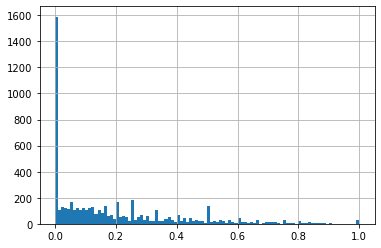

In [10]:
baseline.hist(bins = 100)

<AxesSubplot:>

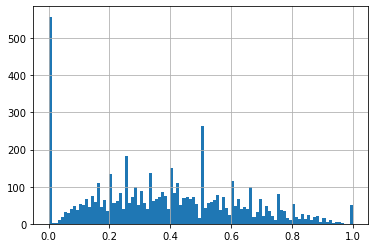

In [11]:
zerosum.hist(bins = 100)

**Result**

The reduction in model bias is more salient when comparing the Popularity Quantile of the top scoring positive items.

The plot above shows the histogram of the popularity quantile of the top scoring positive items of each user for the baseline method.

The plot below shows the same histogram for the zerosum method.


Clearly, whereas the baseline method is prone to model bias, with the top scoring positive items mostly also being the most popular positive items;

the zerosum method is able to greatly reduce model bias.

### Extra -  Basic Statistical Properties when using baseline and zerosum method

In [12]:
baseline = raw_pred_score(model_baseline, test_data_without_neg)
zerosum = raw_pred_score(model_zerosum, test_data_without_neg)

**Distribution of the mean and standard deviation of positive item scores for each user**

**baseline**

<AxesSubplot:>

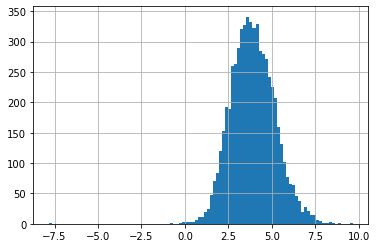

In [13]:
baseline.groupby('uid')['pred'].mean().hist(bins = 100)

<AxesSubplot:>

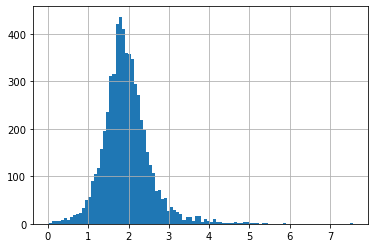

In [14]:
baseline.groupby('uid')['pred'].std().hist(bins = 100)

**zerosum**

<AxesSubplot:>

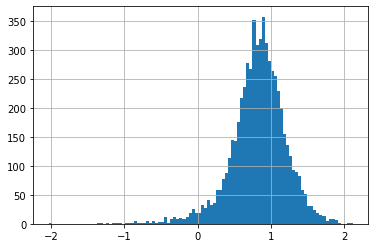

In [15]:
zerosum.groupby('uid')['pred'].mean().hist(bins = 100)

<AxesSubplot:>

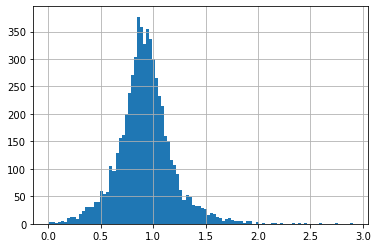

In [16]:
zerosum.groupby('uid')['pred'].std().hist(bins = 100)

**The item results when choosing the top scoring positive item for each user**

**random choice(ideal case)**

In [17]:
test_data_without_neg['random'] = np.random.permutation(199708)

In [18]:
test_data_without_neg = test_data_without_neg.sort_values('random')
one_item_per_user = test_data_without_neg.groupby('uid').head(1)['sid']

<AxesSubplot:>

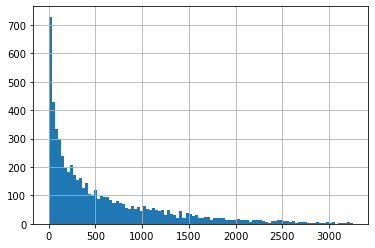

In [19]:
one_item_per_user.hist(bins = 100)

**baseline**

In [20]:
one_item_per_user = baseline.sort_values('pred', ascending = False).groupby('uid').head(1)['sid']

<AxesSubplot:>

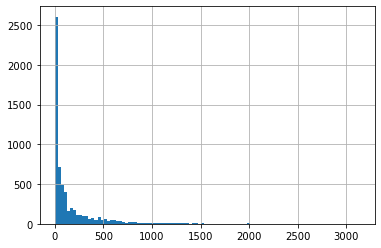

In [21]:
one_item_per_user.hist(bins = 100)

**zerosum**

In [22]:
one_item_per_user = zerosum.sort_values('pred', ascending = False).groupby('uid').head(1)['sid']

<AxesSubplot:>

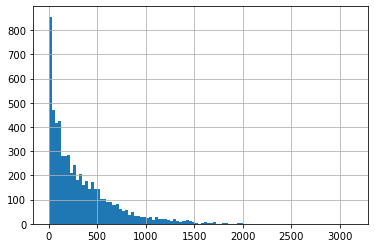

In [23]:
one_item_per_user.hist(bins = 100)